# Modal Tutorial 01: What is modal analysis?
Structural dynamics is the study of how structures respond to dynamic loading.  By dynamic loading, we mean that the forces applied to the structure change over time, as opposed to a static load which remains constant over time.  Examples of dynamic loading might be waves on a boat, wind loading on a turbine or an airplane, or a bumpy road on a car's tires.  Dynamic loading may also originate from inside the structure itself, for example from the engine of a car.  The response to these loads is of utmost importance when designing a structure, as we will need to know if the structure can survive the loads.  Failure can occur due to too much stress, strain, or deflection in a structure.  Therefore, in order to design a structure, we typically need to know what loads will go into the structure, how the structure will respond to those loads, and what the physical limitations or failure methods of the structure are in order to ensure it will work in its service environment.

## So what is Modal Analysis?
Modal analysis is the study of the dynamic characteristics of a system independent from the loads applied to that system.  Each "mode" of the structure has a specific frequency, damping, and deflection shape associated with it.  The frequency of a mode is often called a "modal frequency", "resonant frequency", or "natural frequency".  The damping of each mode is often called "modal damping" and expressed as a fraction of critical damping.  Finally, the shape associated with a mode is called the "mode shape" to differentiate it from more general deflection shapes, which could be associated with any kind of deflection of the system.

Modal analysis will not tell you if your part will break or not.  For that, like stated previously, you will need the loads of the system, the response of the system to those loads, and the failure methods of the structure.  As an analogy: knowing the thickness of a beam does not tell you if that beam is going to break when you use it to hold up your roof, for that you would need to know the loads applied to the beam and the ultimate strength of the beam.  The thickness of the beam is just a characteristic of the beam.  This is similar to modal analysis.  The natural frequency, modal damping, and mode shape of a structure is just a characteristic of the structure.  So what use is modal analysis then?  Well, in a similar way to the beam, where we can use the thickness of the beam to help compute the stress, strain, and deflection of the beam, we can use the modal properties to help us predict the dynamic response of a system, because all dynamic response is formed from a combination of the modes of the structure.

This is a lot of words at this point, so let's examine this more in depth with an example.  At this point, don't worry too much about the code in the next section, just focus on the results and the explanation.

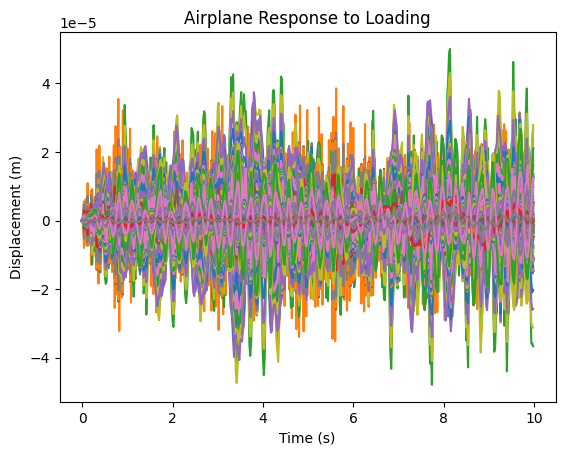

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import sdynpy as sdpy
import sdynpy.demo as demo

plot_kwargs={'node_size':1,'view_from':[-1,1,1]}

# Get the airplane system and geometry from the demo subpackage
system = demo.beam_airplane.system
geometry = demo.beam_airplane.geometry

# Create a modal model to make integration faster
shapes = system.eigensolution(maximum_frequency = 300)
shapes.damping = 0.02
modal_system = shapes[6:].system()

# Create some loads that we will apply to the airplane
sample_rate = 50
num_samples = 500
# We will assume load is coming in through the propeller and the wings
load_locations = sdpy.coordinate_array(string_array=['101Y+',  # Propeller horizontal
                                                     '101Z+',  # Propeller vertical
                                                     '275Z+',  # Right Wing vertical
                                                     '249Z+']) # Left Wing Vertical
load_signals = sdpy.generator.random(load_locations.shape,num_samples,dt=1/sample_rate)
loads = sdpy.time_history_array(np.arange(load_signals.shape[-1])/sample_rate,
                                load_signals,
                                load_locations[:,np.newaxis])
responses = modal_system.time_integrate(
    loads,
    responses={0:modal_system.coordinate},
    integration_oversample=10)

# Draw the forces that we are putting into the structure
geometry.plot_coordinate(load_locations,label_dofs=True,plot_kwargs=plot_kwargs)
# Draw the response to the excitation on the structure
geometry.plot_transient(responses,displacement_scale=200,plot_kwargs=plot_kwargs)
# Plot the Responses
ax = responses.plot()
ax.set_ylabel('Displacement (m)')
ax.set_xlabel('Time (s)')
ax.set_title('Airplane Response to Loading');

Running the above code will pull an airplane model from the SDynPy demonstrations, apply several excitations to it, and get the responses.  The responses are plotted in the figure above, with each colored line corresponding to a different location on the airplane.  Two windows showing the geometry should also appear when the code is run, the first showing the excitation locations at the nose of the plane (due to the propeller) and on the wings (due to wind and turbulence).

![Beam Airplane Excitation Locations](figures/beam_airplane_excitation_locations.png)

**Excitation locations on the plane**

![Beam Airplane Deflection Shape](figures/beam_airplane_deflection_shape.png)

**A deflection shape of the plane at a single instance in time**

Note the response is quite complex.  There are a number of different signals all on top of one another.  Some move quickly up and down, some move more slowly.  It can be a real nightmare decoding this type of signal into meaningful results for your airplane!  One way to get a better view of what is going on is to look in the frequency response of the signals.  This allows us to look at which frequencies have the most response.

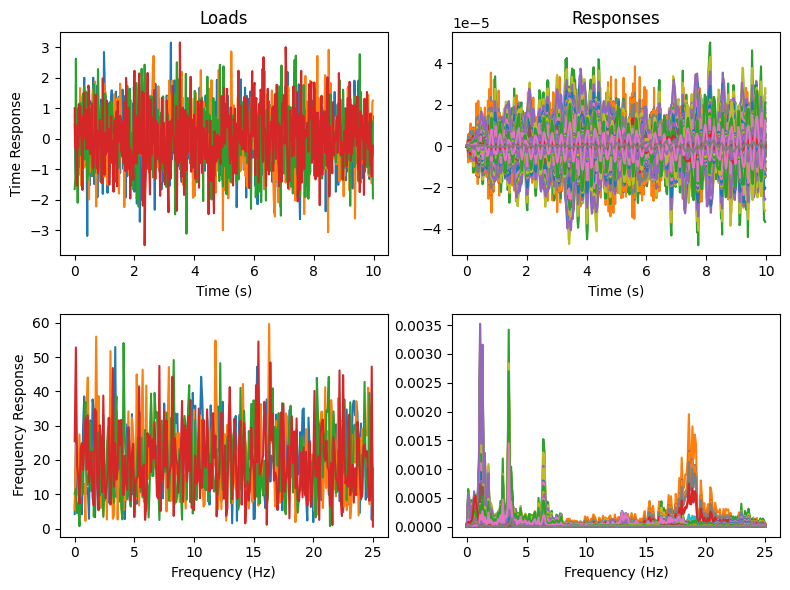

In [2]:
fig,ax = plt.subplots(2,2,figsize=(8,6))
responses_fft = responses.fft()
loads_fft = loads.fft()
responses.plot(ax[0,1])
loads.plot(ax[0,0])
ax[1,1].plot(responses_fft.abscissa.T,np.abs(responses_fft.ordinate).T)
ax[1,0].plot(loads_fft.abscissa.T,np.abs(loads_fft.ordinate).T)
ax[0,0].set_title('Loads')
ax[0,1].set_title('Responses')
ax[0,0].set_ylabel('Time Response')
ax[1,0].set_ylabel('Frequency Response')
for a in ax[0]:
    a.set_xlabel('Time (s)')
for a in ax[1]:
    a.set_xlabel('Frequency (Hz)')
    #a.set_yscale('log')
fig.tight_layout()

Transforming to the frequency domain reveals more information about our structure and its excitation.  In particular, it shows us how the loads and responses to those loads are distributed in frequency.  For the given example, we have applied reasonably "flat" excitation.  The term flat refers to the fact that there are not very large "peaks" in the frequency domain.  While there are some peaks in the data, they are not much larger than surrounding peaks, and the peaks are pretty uniformly distributed across the frequency domain.  The frequency domain of the response on the other hand is very "peaky".  We see below 20 Hz there are big, distinct peaks at around 1, 4, 6, and 19 Hz.  Clearly, the system is preferentially responding at specific frequencies; our force is not biased towards any specific frequency, but still we see the responses are biased towards specific frequencies.  If this were a modal test, these peaks would likely be associated with modes of the system; but one must be careful!  If the excitation is biased towards a given frequency (for example an imbalanced wind turbine spinning at a specific frequency or an engine running at a specific RPM), we may also see this excitation frequency as a peak in the response!  Therefore, in order to characterize the modes of the system, we generally want to know both the excitation and the response to that excitation.  **Modal Analysis is the process by which modes of the system are identified and used to describe a dynamic system.**

## How do we find the modes of the system?

Let's consider again the airplane structure.  Let's apply a force to the tip of the left wing (`201Z+`), and measure the response at the tip of the right wing (`241Z+`).  We can imagine the force is applied with a shaker and measured by a force sensor, and the response is measured using an accelerometer.  We can apply force of a given frequency, and look at the response to that frequency.

In [3]:
# Define the force locations
force_location = sdpy.coordinate_array(string_array=['201Z+'])
response_location = sdpy.coordinate_array(string_array=['241Z+'])
geometry.plot_coordinate(np.concatenate((force_location,response_location)),
                         label_dofs=True,plot_kwargs=plot_kwargs);

![Force and Response Locations](figures/wingtip_frequency_demonstration.png)

For this case, we will look at frequencies around that first peak in the frequency domain of the responses.  We will excite the structure at 0.8 Hz, 1.2 Hz, and 1.6 Hz and see what the responses look like for each.

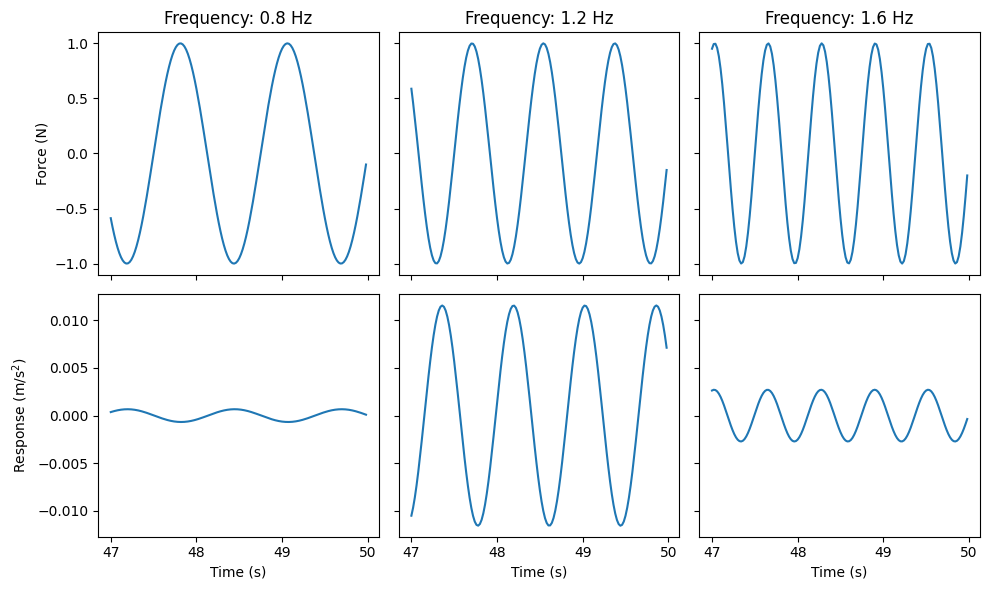

In [4]:
frequencies = [0.8,1.2,1.6]
num_samples = sample_rate*50 # Make sure signal is long enough for the transient to die out
fig,ax = plt.subplots(2,len(frequencies),figsize=(10,6),sharex=True,sharey='row')
for frequency,a in zip(frequencies,ax.T):
    load_signal = sdpy.generator.sine(frequency,1/sample_rate,num_samples)
    loads = sdpy.time_history_array(
        np.arange(load_signal.shape[-1])/sample_rate,
        load_signal,
        force_location)
    responses = modal_system.time_integrate(loads,
                                            responses={2:response_location},
                                            integration_oversample=10)
    # Only plot the last second
    loads.extract_elements(slice(-3*sample_rate,None)).plot(a[0])
    responses.extract_elements(slice(-3*sample_rate,None)).plot(a[1])
    a[0].set_title('Frequency: {:0.1f} Hz'.format(frequency))
    a[1].set_xlabel('Time (s)')
ax[0,0].set_ylabel('Force (N)')
ax[1,0].set_ylabel('Response (m/s$^2$)')

fig.tight_layout()

In the above plots, it is obvious that if we put in a constant amplitude sine wave of 1 N at different frequencies, the response amplitude does not stay fixed, which suggests that the system is amplifying or attenuating the response based on its frequency.  One could imagine tracing out a frequency vs. amplitude curve by exciting the structure at a large number of frequencies; however, this would take a long time in practice.  Instead, we can develop a single signal that sweeps through a frequency range of interest.

Text(0.5, 1.0, 'Response to Increasing Excitation Frequency')

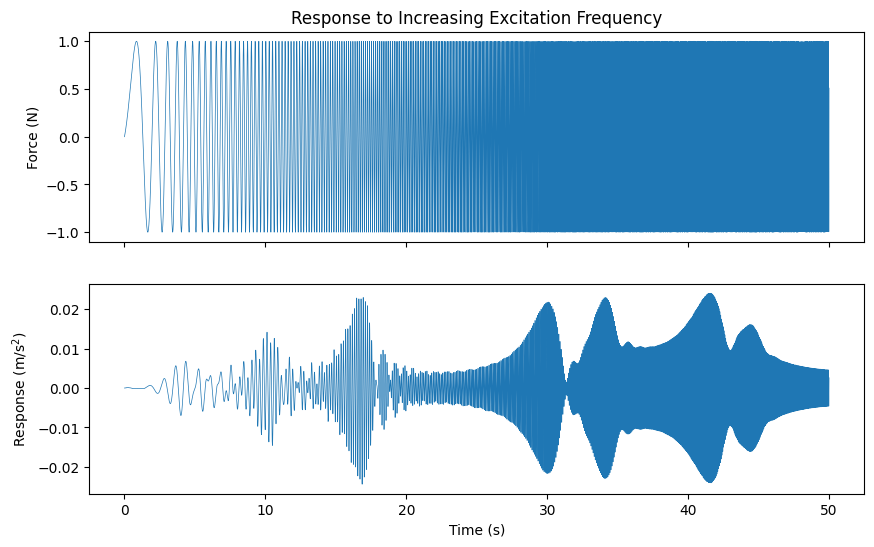

In [5]:
chirp_signal = sdpy.generator.chirp(frequency_min = 0.125,
                                    frequency_max = 20,
                                    signal_length = 50,
                                    dt = 1/sample_rate/10)
chirp_loads = sdpy.time_history_array(
    np.arange(chirp_signal.shape[-1])/sample_rate/10,
    chirp_signal,
    force_location)
chirp_responses = modal_system.time_integrate(chirp_loads,
                                              responses={2:response_location})
fig,ax = plt.subplots(2,1,figsize=(10,6),sharex=True)
chirp_loads.plot(ax[0],plot_kwargs={'linewidth':0.5})
chirp_responses.plot(ax[1],plot_kwargs={'linewidth':0.5})
ax[0].set_ylabel('Force (N)')
ax[1].set_ylabel('Response (m/s$^2$)')
ax[1].set_xlabel('Time (s)')
ax[0].set_title('Response to Increasing Excitation Frequency')

The amplitude of response to this swept excitation demonstrates how the system amplifies or attenuates responses.  We can see this better if we convert to the frequency domain and compute what is called the **"Frequency Response Function"**.

array([<Axes: ylabel='Phase'>,
       <Axes: xlabel='Frequency', ylabel='Amplitude'>], dtype=object)

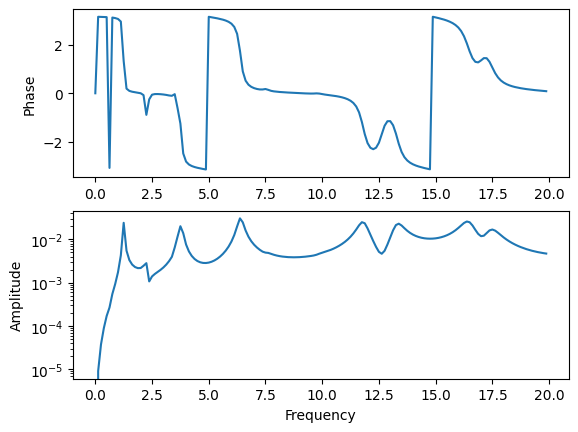

In [6]:
frequencies = np.arange(8*20)/8
frequency_response_function = shapes[6:].compute_frf(frequencies,response_location,force_location)

frequency_response_function.plot()

The Frequency Response Function or FRF can be thought of as the ratio of the response to the excitation, and therefore shows how much the excitation is amplified or attenuated by the structure.  Peaks in the FRF generally correlate to modes of the structure, as it has already been normalized with respect to the force.  If we overlay the time history from the sweep with the FRF, we will see that the peaks in the FRF correspond to frequencies in the sweep where the time histories are amplified.

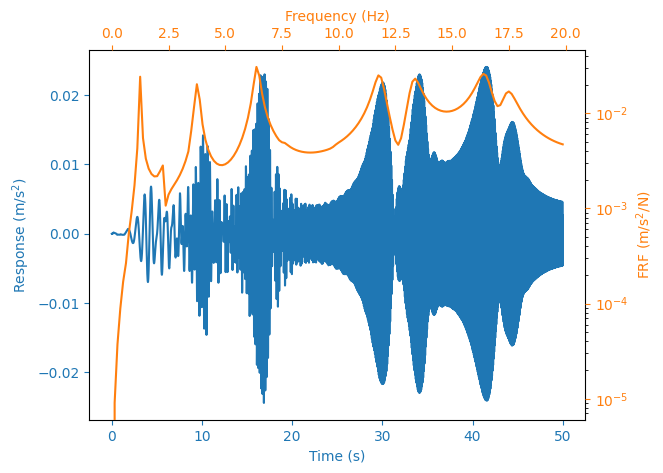

In [7]:
fig=plt.figure()
ax=fig.add_subplot(111, label="1")
ax2=fig.add_subplot(111, label="2", frame_on=False)

ax.plot(
    chirp_responses.abscissa.squeeze(),
    chirp_responses.ordinate.squeeze(),
    color="C0")
ax.set_xlabel("Time (s)", color="C0")
ax.set_ylabel("Response (m/s$^2$)", color="C0")
ax.tick_params(axis='x', colors="C0")
ax.tick_params(axis='y', colors="C0")

ax2.plot(
    frequency_response_function.abscissa.squeeze(),
    np.abs(frequency_response_function.ordinate.squeeze()),
    color="C1")
ax2.xaxis.tick_top()
ax2.yaxis.tick_right()
ax2.set_xlabel('Frequency (Hz)', color="C1") 
ax2.set_ylabel('FRF (m/s$^2$/N)', color="C1")       
ax2.xaxis.set_label_position('top') 
ax2.yaxis.set_label_position('right') 
ax2.tick_params(axis='x', colors="C1")
ax2.tick_params(axis='y', colors="C1")
ax2.set_yscale('log')

Note that the FRF also contains a phase quantity, which specifies how much the response is shifted in time from the excitation.  A phase of zero would mean that the response peaks when the excitation peaks.  A phase of 90 degrees would mean that the response peaks when the force is zero, and the response is zero when the force peaks.

Obvious from the above plot is the fact that each mode is associated with a specific frequency, as amplification of the response can be seen at these specific frequencies.  However, perhaps more surprising is that each mode is also associated with a specific deformation pattern or "mode shape".  If instead of placing just one accelerometer on the wing tip, we instead put instruments all over the structure, we can look at the deflection patterns around each peak.  The deflection shapes can be picked from the chirp time data or from the FRFs.

In [8]:
chirp_signal = sdpy.generator.chirp(frequency_min = 0.125,
                                    frequency_max = 20,
                                    signal_length = 50,
                                    dt = 1/sample_rate/10)
chirp_loads = sdpy.time_history_array(
    np.arange(chirp_signal.shape[-1])/sample_rate/10,
    chirp_signal,
    force_location)
chirp_responses = modal_system.time_integrate(
    chirp_loads,
    {2:modal_system.coordinate})
chirp_responses = chirp_responses.extract_elements(slice(None,None,10))
frequencies = np.arange(8*20)/8+1/8
frequency_response_function = shapes[6:].compute_frf(frequencies,references = force_location)

geometry.plot_transient(chirp_responses,displacement_scale=10,plot_kwargs=plot_kwargs)
geometry.plot_deflection_shape(frequency_response_function,plot_kwargs=plot_kwargs);

![Deflection Shape 1](figures/deflection_shape_1.png)
![Deflection Shape 2](figures/deflection_shape_2.png)
![Deflection Shape 3](figures/deflection_shape_3.png)
![Deflection Shape 4](figures/deflection_shape_4.png)
![Deflection Shape 5](figures/deflection_shape_5.png)
![Deflection Shape 6](figures/deflection_shape_6.png)

## Summary
In this tutorial we covered some of the basics of modal analysis.  We introduced an example system, applied some loads to it, and determined the system's response to that load.  The time response was quite complicated due to the complicated loads and their interaction with the system.  We could make things a bit clearer by transforming to the frequency domain, but the results here are still a combination of system dynamics and excitation load.  Instead, we moved to a different test setup where we apply a known or measured load to a system, which lets us normalize the responses to the loads applied.  We saw that by sweeping across frequencies, we could trace out the amplitude of the system's response vs. frequency.  We introduced the frequency response function, or FRF, and found that we could pull modal frequencies and deflection shapes from the peaks.  In the next tutorial, we will take a step back to a more simple problem, and discuss some of the theory behind vibration and modal analysis.